<a href="https://colab.research.google.com/github/EmmanuelAdio/AAI-Coursework/blob/main/AAI_Coursework_CNN_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>  ***Training Convolutional Neural Networks Using Genetic Algorithms and Enhancing Performance with Ensemble Learning*** </center>

---

## **Abstract**
This tutorial explores how to train Convolutional Neural Networks (CNNs) using GA, evaluating different CNN architectures to assess their effectiveness. After comparing GA-trained models in terms of accuracy, convergence speed, and computational cost, we further enhance performance by applying ensemble learning techniques. The goal is to demonstrate how model ensembling can improve classification accuracy by leveraging multiple GA-optimized networks for better decision-making.

## **Learning objective**
By the end of this tutorial, you will:

- **Understand Genetic Algorithms (GA)** and how they can be used to optimize Convolutional Neural Networks (CNNs).  
- **Implement GA for CNN training in PyTorch**, including selection, crossover, and mutation techniques.  
- **Compare different CNN models trained using GA**, analyzing accuracy, convergence, and computational efficiency.  
- **Apply Ensemble Learning techniques** to improve classification performance by combining GA-trained CNNs.  
- **Visualize model performance** using accuracy/loss curves and per-class accuracy analysis.  
- **Gain practical experience** in evolutionary optimization and ensemble learning, enhancing deep learning pipelines.  

## **Table of Contents**
1. [Introduction](#Introduction)
2. [CNN Architectures Used](#CNN-Architectures-Used)
3. [Implementing Genetic Algorithm for CNN Training](#Implementing-Genetic-Algorithm-for-CNN-Training)
4. [Comparing CNNs Trained Using Genetic Algorithms](#Comparing-CNNs-Trained-Using-Genetic-Algorithms)
5. [Ensemble Learning: Combining GA-Trained CNNs](#Ensemble-Learning-Combining-GA-Trained-CNNs)
6. [Evaluation and Visualization](#Evaluation-and-Visualization)
7. [Conclusion](#Conclusion)
8. [References](#References)
<br>
<br>
---


## **Introduction**
Training **Convolutional Neural Networks (CNNs)** efficiently is a key challenge in deep learning. Traditional optimization techniques such as **Stochastic Gradient Descent (SGD)** and **Adam** rely on backpropagation to update model weights. However, **Genetic Algorithms (GAs)** provide an alternative approach by evolving network parameters through a population-based optimization process.

This tutorial explores how **Genetic Algorithms (GA) can be used to train CNNs** without relying on gradient-based methods. By implementing **selection, crossover, and mutation**, we optimize CNN weights across multiple generations. The **performance of GA-trained CNNs** is then evaluated and compared, highlighting accuracy trends and computational costs.

Finally, we **apply ensemble learning techniques** to combine multiple GA-trained models into a single classifier, aiming to improve classification performance. This hybrid approach leverages the strengths of different models, leading to a more robust deep learning solution.


## **What is a Genetic Algorithm?**
A **Genetic Algorithm (GA)** is an evolutionary optimization technique inspired by **natural selection**. It evolves a population of solutions over generations to optimize a given objective function. Instead of using gradients to adjust weights (as in traditional deep learning), GA applies:
- **Selection**: Choosing the best-performing models (high accuracy CNNs).
- **Crossover**: Mixing features from selected models to create new ones.
- **Mutation**: Slightly altering model parameters to introduce diversity.


---
## Libraries


In [27]:
# PyTorch libraries for neural network operations and optimization algorithms.
import torch                                    # torch: PyTorch library for tensor operations and neural network functionalities.
import torch.nn as nn                           # torch.nn: PyTorch library for neural network layers and operations.
import torch.nn.functional as F                 # torch.nn.functional: PyTorch library for activation functions and other neural network operations.
import torch.optim as optim                     # torch.optim: PyTorch library for optimization algorithms like SGD and Adam.
import torchvision                              # torchvision: PyTorch library for computer vision tasks.
import torchvision.transforms as transforms     # torchvision.transforms: PyTorch library for data augmentation and preprocessing of images.

import matplotlib.pyplot as plt                 # matplotlib.pyplot: For plotting graphs and visualizing images.
import numpy as np                              # numpy: For numerical operations and array manipulations.

import time                                     # time: For measuring training and evaluation time.
import random                                   # random: For random operations like shuffling and selecting random samples.

In [28]:
# print the system information
print("Torch version : ", torch.__version__)                                  # PyTorch version
print("Cuda availability : ", torch.cuda.is_available(), "\n")                # GPU availability

if torch.cuda.is_available():
	print("Device name : ",torch.cuda.get_device_name(0))        # GPU device name
	print("Device ID : ",torch.cuda.current_device())          # GPU device ID
else:
	print("CUDA is not available. Running on CPU.")

Torch version :  2.5.1+cu124
Cuda availability :  True 

Device name :  NVIDIA A100-SXM4-40GB
Device ID :  0


---
## **Dataset Used: CIFAR-10**

The **CIFAR-10** dataset is used for training and evaluating the CNN models in this tutorial. It is a well-known benchmark dataset in computer vision, widely used for image classification tasks.

### **Dataset Overview**
- **Total Images**: 60,000
- **Image Size**: 32x32 pixels
- **Number of Classes**: 10
- **Training Set**: 50,000 images
- **Test Set**: 10,000 images
- **Color Channels**: RGB (3 channels)

### **CIFAR-10 Classes**
The dataset contains **10 categories**, each with **6,000 images**:
1. **Plane**  
2. **Car**  
3. **Bird**
4. **Cat**  
5. **Deer**  
6. **Dog**
7. **Frog**
8. **Horse**
9. **Ship**
10. **Truck**

In [29]:
#CIFAR10 dataset

# Load and normalise CIFAR10 dataset from Source [1]
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size for loading data
batch_size = 4

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### End of source [1]

# source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Files already downloaded and verified
Files already downloaded and verified


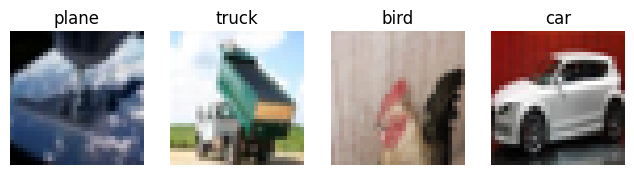

In [30]:
#function that shows images with their labels
def show_images_labels(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(2, 5, i + 1)
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"{classes[labels[i]]}")
        plt.axis('off')
    plt.show()

# get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images_labels(images, labels)

---

## **CNN Architectures Used** <a id="CNN-Architectures-Used"></a>

### **What is a CNN?**
A **Convolutional Neural Network (CNN)** is a type of deep learning model specifically designed for **image classification and processing**. Unlike traditional neural networks, CNNs use specialized layers to extract spatial and hierarchical features from images.

CNNs are widely used in **computer vision tasks**, such as **object detection, facial recognition, and medical imaging**, due to their ability to automatically learn important features from raw pixel data.

---

### **How Do CNNs Work?**
CNNs operate by applying a series of transformations to an input image, gradually extracting meaningful patterns:

| **Stage** | **Description** |
|-----------|---------------|
| **1. Convolution** | Applies **filters (kernels)** to detect patterns like edges and textures. |
| **2. Activation Function (ReLU)** | Introduces **non-linearity** to allow the model to learn complex features. |
| **3. Pooling (Max/Average)** | Downsamples the feature maps, reducing computation and improving generalization. |
| **4. Flattening** | Converts multi-dimensional feature maps into a 1D vector for classification. |
| **5. Fully Connected (FC) Layers** | Processes extracted features and makes predictions. |

Each layer contributes to making CNNs **highly efficient for image recognition tasks**.

---

### **CNN Architectures Used in This Project**
This tutorial implements and compares two CNN architectures:
1. **A Custom CNN model**
2. **LeNet-5 (Modified for CIFAR-10)**

Both models are trained using **Genetic Algorithms (GA)** instead of conventional gradient-based optimization.

---

### **Custom CNN Model**
The **Custom CNN** is designed specifically for **CIFAR-10 classification**, featuring:
- **Two convolutional layers** for hierarchical feature extraction.
- **Two pooling layers** to reduce dimensionality.
- **Two fully connected layers** for classification.

#### ** Model Architecture Breakdown**
| **Layer Type**  | **Details** |
|-----------------|------------|
| **Conv2D (1st Layer)** | 32 filters, kernel size **3x3**, stride **1**, padding **1** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Conv2D (2nd Layer)** | 64 filters, kernel size **3x3**, stride **1**, padding **1** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Flatten**     | Converts feature maps into a 1D vector |
| **Fully Connected (FC1)** | 128 neurons, ReLU |
| **Dropout**     | 50% dropout to prevent overfitting |
| **Fully Connected (FC2 - Output Layer)** | 10 neurons, Log Softmax for classification |

---

### **LeNet-5 (Modified for CIFAR-10)**
LeNet-5 is a **classic CNN architecture** originally designed for handwritten digit recognition (**MNIST**). In this project, it has been **modified to handle CIFAR-10**, which consists of **RGB images** instead of grayscale.

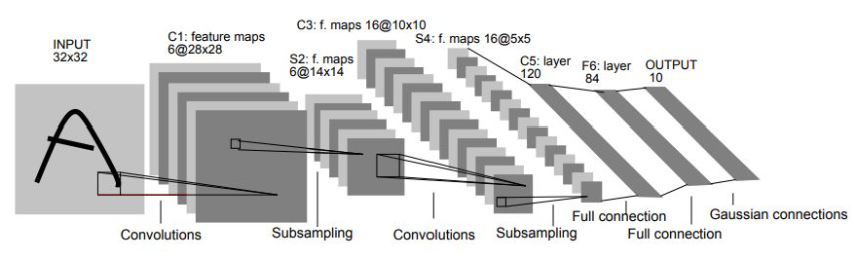
[3]


#### ** Model Architecture Breakdown**
| **Layer Type**  | **Details** |
|-----------------|------------|
| **Conv2D (1st Layer)** | 6 filters, kernel size **5x5**, padding **2** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Conv2D (2nd Layer)** | 16 filters, kernel size **5x5** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Flatten**     | Converts feature maps into a 1D vector |
| **Fully Connected (FC1)** | 120 neurons, ReLU |
| **Fully Connected (FC2)** | 84 neurons, ReLU |
| **Fully Connected (Output Layer)** | 10 neurons (one per CIFAR-10 class) |



In [31]:
# Define the CNN model from Source [2] modified so it can be used for CIFAR10 dataset
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
### End of source [2]

In [33]:
class CNN_2(nn.Module):
    def __init__(self, num_classes=10, grayscale=False):
        super(CNN_2, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=5 * 5 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view(-1, 5 * 5 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)

In [35]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(

            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas


### Key training and testing functions.

In [ ]:
def train_nn(model, trainloader, criterion, optimizer, epochs=2, use_gpu=True, lr_scheduler=False):
    """
    Train a PyTorch CNN model efficiently.

    Args:
        model: PyTorch model to train.
        trainloader: DataLoader containing training data.
        criterion: Loss function.
        optimizer: Optimizer (Adam, SGD, etc.).
        epochs (int, optional): Number of training epochs. Default is 2.
        use_gpu (bool, optional): If True, enables GPU acceleration.
        lr_scheduler (bool, optional): If True, reduces learning rate when loss stops improving.

    Returns:
        train_losses: List of training losses over epochs.
        train_accuracies: List of training accuracies.
        total_training_time: Total training time.
    """

    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    train_losses = []
    train_accuracies = []
    total_training_time = 0

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5) if lr_scheduler else None

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Adjust learning rate if using scheduler
        if lr_scheduler:
            scheduler.step(epoch_loss)

        epoch_training_time = time.time() - epoch_start_time
        total_training_time += epoch_training_time

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train_Accuracy: {epoch_accuracy:.2f}% | Time: {epoch_training_time:.2f}s")

    return train_losses, train_accuracies, total_training_time

In [39]:
def test_nn(model, testloader, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns overall accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        overall_accuracy (float): Accuracy of the model on the test set.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total

    # print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy


In [40]:
def test_4_random_images(testloader, model, classes, use_gpu=True):
    """
    Visually tests the model on 4 random images from the test set and computes approximate accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): Whether to use GPU if available.

    Returns:
        accuracy (float): Model accuracy on the 4 randomly selected images.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU
    model.eval()  # Set model to evaluation mode

    # Get a random batch from the testloader
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Select 4 random indices from the batch
    indices = random.sample(range(len(images)), 4)
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Move data to GPU if available
    selected_images, selected_labels = selected_images.to(device), selected_labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)

    # Compute accuracy
    correct = (predicted == selected_labels).sum().item()
    accuracy = correct / len(selected_labels) * 100

    # Display images with labels and predictions
    show_images_labels(selected_images.cpu(), selected_labels.cpu())
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
    print(f'Accuracy on these 4 images: {accuracy:.2f}%')

    return accuracy

In [41]:
def test_nn_per_class(testloader, model, classes, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns per-class accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        class_accuracies (dict): Dictionary containing accuracy for each class.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update per-class statistics
            for label, prediction in zip(labels, predictions):
                total_pred[classes[label.item()]] += 1  # Count total instances of each class
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1  # Count correct predictions

    # Compute per-class accuracy
    class_accuracies = {
        classname: (100 * correct_pred[classname] / total_pred[classname]) if total_pred[classname] > 0 else 0.0
        for classname in classes
    }

    print("Finished per-class testing.")
    return class_accuracies


---

## **Implementing Genetic Algorithm for CNN Training** <a id="Implementing-Genetic-Algorithm-for-CNN-Training"></a>
*implementation of selection, mutation, and crossover for CNN weight optimization.*

In [ ]:
def compute_fitness(criterion, model, optimizer, trainloader, testloader, epochs):
    """
    Computes the fitness of a model by training and evaluating its accuracy.

    Args:
        criterion: Loss function.
        model: PyTorch model to train and evaluate.
        optimizer: Optimizer (Adam, SGD, etc.).
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        epochs (int): Number of training epochs.

    Returns:
        fitness (float): Accuracy of the model on the test set.
    """
    # Train the model
    train_nn(model, trainloader, criterion, optimizer, epochs)

    # Test the model
    fitness = test_nn(model, testloader)
    return fitness

In [43]:
# write a function to initialise the population
def initialise_population(population_size, model_class):
    """
    Initializes a population of models.

    Args:
        population_size (int): Number of models in the population.
        model_class (class): The class of the model to be instantiated.

    Returns:
        population (list): List of instantiated models.
    """
    population = []
    for i in range(population_size):
        model = model_class()
        population.append(model)
    return population

In [ ]:
# write the function to perform the crossover operation
def crossover(parent1, parent2, use_gpu=True):
    """
    Performs crossover operation between two parent models to produce two child models.

    Args:
        parent1: First parent model (CNN or LeNet5).
        parent2: Second parent model (CNN or LeNet5).
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        child1: First child model.
        child2: Second child model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

    if isinstance(parent1, CNN) and isinstance(parent2, CNN):
        # Initialize child models
        child1 = CNN().to(device)
        child2 = CNN().to(device)

        # Perform crossover on the convolutional layers
        child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:16], parent2.conv1.weight.data[16:]), dim=0).to(device)
        child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:16], parent1.conv1.weight.data[16:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.fc1.weight.data = torch.cat((parent1.fc1.weight.data[:64], parent2.fc1.weight.data[64:]), dim=0).to(device)
        child2.fc1.weight.data = torch.cat((parent2.fc1.weight.data[:64], parent1.fc1.weight.data[64:]), dim=0).to(device)

    elif isinstance(parent1, LeNet5) and isinstance(parent2, LeNet5):
        # Initialize child models
        child1 = LeNet5(num_classes=10).to(device)
        child2 = LeNet5(num_classes=10).to(device)

        # Perform crossover on the convolutional layers
        child1.features[0].weight.data = torch.cat((parent1.features[0].weight.data[:3], parent2.features[0].weight.data[3:]), dim=0).to(device)
        child2.features[0].weight.data = torch.cat((parent2.features[0].weight.data[:3], parent1.features[0].weight.data[3:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.classifier[0].weight.data = torch.cat((parent1.classifier[0].weight.data[:60], parent2.classifier[0].weight.data[60:]), dim=0).to(device)
        child2.classifier[0].weight.data = torch.cat((parent2.classifier[0].weight.data[:60], parent1.classifier[0].weight.data[60:]), dim=0).to(device)
        
    elif isinstance(parent1, CNN_2) and isinstance(parent2, CNN_2):
        # Initialize child models
        child1 = CNN_2().to(device)
        child2 = CNN_2().to(device)

        # Perform crossover on the convolutional layers
        child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:6], parent2.conv1.weight.data[6:]), dim=0).to(device)
        child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:6], parent1.conv1.weight.data[6:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.fc.weight.data = torch.cat((parent1.fc.weight.data[:60], parent2.fc.weight.data[60:]), dim=0).to(device)
        child2.fc.weight.data = torch.cat((parent2.fc.weight.data[:60], parent1.fc.weight.data[60:]), dim=0).to(device)
    else:
        raise ValueError("Unsupported model types for crossover")

    return child1, child2

In [45]:
# write the function to perform the mutation operation
def mutate(model, mutation_rate, use_gpu=True):
    """
    Applies mutation to the model parameters by adding random noise.

    Args:
        model: PyTorch model to mutate.
        mutation_rate (float): Probability of mutation for each parameter.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        model: Mutated PyTorch model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available

    for param in model.parameters():
        if torch.rand(1).item() < mutation_rate:  # Check if mutation should be applied
            param.data += torch.randn(param.data.size()).to(device) * 0.1  # Add random noise to the parameter

    return model

In [46]:
def run_genetic_algorithm(model_class, criterion, population_size, generations, trainloader, testloader, epochs, mutation_rate, use_gpu=True):
    """
    Runs a Genetic Algorithm (GA) to optimize a neural network model.

    Args:
        population_size (int): Number of models in the population.
        generations (int): Number of generations to evolve.
        trainloader: PyTorch DataLoader for training data.
        testloader: PyTorch DataLoader for test data.
        epochs (int): Number of epochs for fitness evaluation.
        mutation_rate (float): Probability of mutation.

    Returns:
        results (dict): Dictionary containing:
            - 'best_model': Best model from the final generation.
            - 'generation_times': List of time taken for each generation.
            - 'best_accuracies': List of best accuracies from each generation.
    """


    # Initialize the population
    population = initialise_population(population_size, model_class)

    # Tracking metrics
    generation_times = []
    best_accuracies = []

    # Start Genetic Algorithm process
    for generation in range(generations):
        print(f"\nGeneration {generation + 1}")

        best_accuracy = 0
        best_model = None
        fitness_scores = np.zeros(population_size)  # Preallocate array for fitness scores

        # Start timer for the generation
        start_time = time.time()

        # Evaluate fitness for each model
        for i, model in enumerate(population):
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define optimizer
            fitness = compute_fitness(criterion, model, optimizer, trainloader, testloader,epochs)
            fitness_scores[i] = fitness

            if fitness > best_accuracy:
                best_accuracy = fitness
                best_model = model

        # End timer for the generation
        end_time = time.time()
        generation_time = end_time - start_time

        # Store time and best accuracy for visualization
        generation_times.append(generation_time)
        best_accuracies.append(best_accuracy)

        print(f'Best accuracy in generation {generation + 1} = {best_accuracy:.4f}')
        print(f'Time taken for generation {generation + 1}: {generation_time:.2f} seconds')

        # **Parent Selection**
        top_indices = np.argsort(fitness_scores)[-population_size // 2:]  # Get top 50%
        selected_parents = [population[i] for i in top_indices]

        next_generation = []

        # **Crossover & Mutation**
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i + 1]

            # Perform crossover
            child1, child2 = crossover(parent1, parent2)

            # Apply mutation
            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)

            next_generation.append(child1)
            next_generation.append(child2)

        # Ensure the population size remains constant
        population = next_generation[:population_size]

    # **Return the best model and collected data for visualization**
    results = {
        "best_model": best_model,
        "generation_times": generation_times,
        "best_accuracies": best_accuracies
    }

    return results


---
## **Comparing CNNs Trained Using Genetic Algorithms** <a id="Comparing-CNNs-Trained-Using-Genetic-Algorithms"></a>
*Analyzing accuracy, training time, and performance trends across generations.*


In [47]:
#print the system stats that the models will be trained on such as the number of classes and the number of images in the training and test sets
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(trainloader.dataset)}")
print(f"Number of test images: {len(testloader.dataset)}")

Number of classes: 10
Number of training images: 50000
Number of test images: 10000


In [ ]:
#Global variables used on all models to keep comparisions fair
#genetic algorithm parameters
GENERATIONS = 4
POPULATION_SIZE = GENERATIONS * 2
MUTATION_RATE = 0.1

#training parameters
EPOCHS = 2
USE_GPU = True
CRITERION = nn.CrossEntropyLoss()

### Base model results


In [50]:
#create an instance of the CNN model
testing_model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testing_model.parameters(), lr=0.001)

# Train the model
start_time = time.time()
train_nn(testing_model,trainloader, criterion, optimizer, 5)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/5 | Loss: 1.5278 | Accuracy: 44.48% | Time: 43.04s
Epoch 2/5 | Loss: 1.2905 | Accuracy: 54.11% | Time: 41.64s
Epoch 3/5 | Loss: 1.1991 | Accuracy: 57.71% | Time: 41.83s
Epoch 4/5 | Loss: 1.1372 | Accuracy: 60.06% | Time: 42.13s
Epoch 5/5 | Loss: 1.0844 | Accuracy: 61.85% | Time: 41.81s
Training time: 210.62 seconds


In [ ]:
# Initialize base models
models = {
    "CNN_1": CNN(),
    "CNN_2": CNN_2(),
    "LeNet-5": LeNet5()
}

# Define loss function
criterion = nn.CrossEntropyLoss()

# Store results
results = {}

# Train and test each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_losses, train_accuracies, training_time = train_nn(model, trainloader, criterion, optimizer, epochs=10)

    # Test model
    final_accuracy = test_nn(model, testloader, use_gpu=USE_GPU)

    # Store results
    results[model_name] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "final_test_accuracy": final_accuracy,
        "total_training_time": training_time
    }

    # Print results
    print(f"{model_name} Final Accuracy: {final_accuracy:.2f}%")
    print(f"{model_name} Training Time: {training_time:.2f} seconds\n")




Training Base CNN...
Epoch 1/10 | Loss: 1.5212 | Accuracy: 44.39% | Time: 41.57s
Epoch 2/10 | Loss: 1.2558 | Accuracy: 55.82% | Time: 41.88s
Epoch 3/10 | Loss: 1.1547 | Accuracy: 59.43% | Time: 42.42s
Epoch 4/10 | Loss: 1.0852 | Accuracy: 62.12% | Time: 42.13s
Epoch 5/10 | Loss: 1.0369 | Accuracy: 63.71% | Time: 41.76s
Epoch 6/10 | Loss: 1.0024 | Accuracy: 64.97% | Time: 41.86s
Epoch 7/10 | Loss: 0.9689 | Accuracy: 66.41% | Time: 41.89s
Epoch 8/10 | Loss: 0.9452 | Accuracy: 67.22% | Time: 41.81s
Epoch 9/10 | Loss: 0.9198 | Accuracy: 68.11% | Time: 41.99s
Epoch 10/10 | Loss: 0.9000 | Accuracy: 68.63% | Time: 42.27s
Base CNN Final Accuracy: 63.04%
Base CNN Training Time: 419.59 seconds


Training Base 2...
Epoch 1/10 | Loss: 1.7240 | Accuracy: 36.65% | Time: 40.14s
Epoch 2/10 | Loss: 1.5819 | Accuracy: 42.49% | Time: 39.85s
Epoch 3/10 | Loss: 1.5203 | Accuracy: 45.30% | Time: 39.07s
Epoch 4/10 | Loss: 1.4611 | Accuracy: 47.76% | Time: 38.94s
Epoch 5/10 | Loss: 1.4379 | Accuracy: 49.10% 

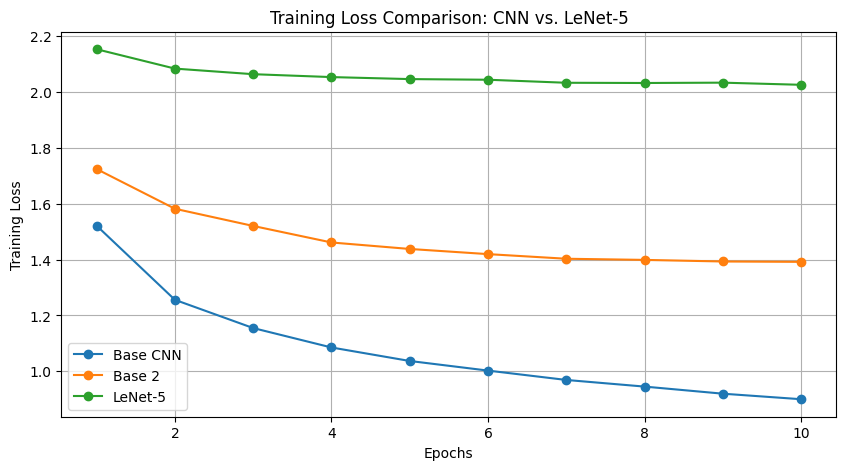

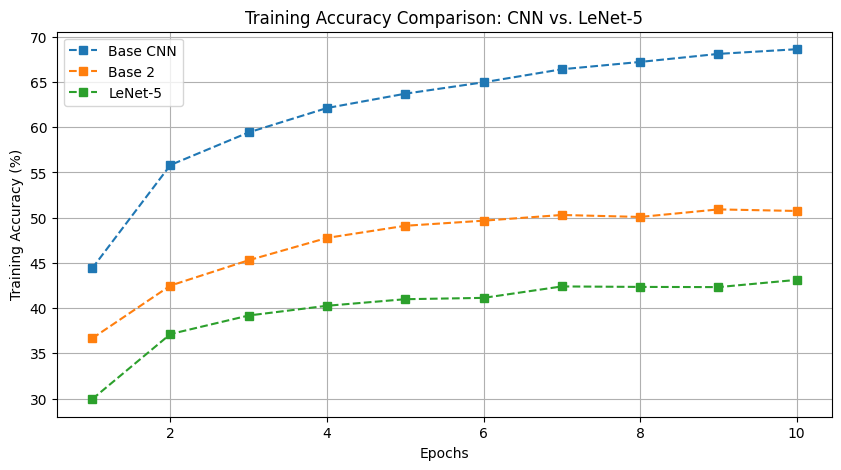

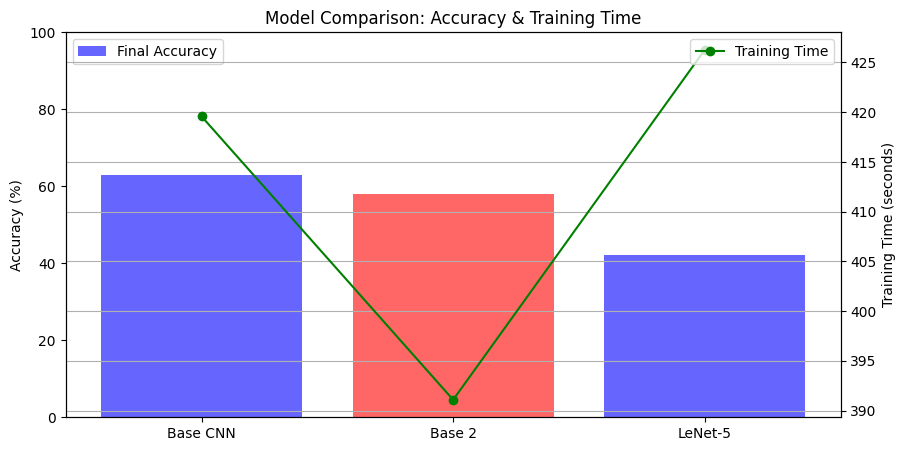

In [ ]:
# Extracting results for plotting
train_losses = {name: results[name]["train_losses"] for name in models}
train_accuracies = {name: results[name]["train_accuracies"] for name in models}
final_accuracies = {name: results[name]["final_test_accuracy"] for name in models}
training_times = {name: results[name]["total_training_time"] for name in models}

# Plot Training Loss Progression
plt.figure(figsize=(10, 5))
for model_name, losses in train_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=model_name, marker="o", linestyle="-")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison: CNN_1 vs. CNN_2 vs. LeNet-5")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy Progression
plt.figure(figsize=(10, 5))
for model_name, accuracies in train_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model_name, marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy Comparison: CNN_1 vs. CNN_2 LeNet-5")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Time and Accuracy Comparison
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart for accuracy
ax1.bar(final_accuracies.keys(), final_accuracies.values(), color=['blue', 'orange', 'green'], alpha=0.6, label="Final Accuracy")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 100)

# Line plot for training time
ax2 = ax1.twinx()
ax2.plot(training_times.keys(), training_times.values(), marker="o", color="yellow", label="Training Time")
ax2.set_ylabel("Training Time (seconds)")

# Labels and title
plt.title("Model Comparison: Accuracy & Training Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
#save the models after they have been trained
torch.save(models["CNN_1"].state_dict(), "cnn_1.pth")
torch.save(models["CNN_2"].state_dict(), "cnn_2.pth")
torch.save(models["LeNet-5"].state_dict(), "lenet5.pth")

### Genetic algorithm results

In [ ]:
# Define models
models = {
    "CNN_1": CNN,
    "CNN_2": CNN_2,
    "LeNet-5": lambda: LeNet5(num_classes=10)
}

# Store results
ga_results = {}

for model_name, model_class in models.items():
    print(f"\nRunning Genetic Algorithm for {model_name}...")

    # Run GA for this model
    ga_results[model_name] = run_genetic_algorithm(model_class, CRITERION, POPULATION_SIZE, GENERATIONS, trainloader, testloader, epochs=EPOCHS, mutation_rate=MUTATION_RATE)


Running Genetic Algorithm for Base CNN...

Generation 1


AttributeError: 'DataLoader' object has no attribute 'to'

In [ ]:
# compare the models
# Print Summary for Each Model
for model_name, results in ga_results.items():
    print(f"\n{model_name} Final Best Accuracy: {results['best_accuracies'][-1]:.2f}%")
    print(f"{model_name} Time Taken Per Generation: {results['generation_times']}")

# Extract results for visualization
# Extract best accuracies and generation times for each model
best_accuracies = {name: results["best_accuracies"] for name, results in ga_results.items()}
generation_times = {name: results["generation_times"] for name, results in ga_results.items()}


plt.figure(figsize=(10, 5))

# Plot accuracy curves for all models
for model_name, accuracies in best_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker="o", linestyle="-", label=model_name)

plt.xlabel("Generation")
plt.ylabel("Best Accuracy (%)")
plt.title("Genetic Algorithm: Accuracy Progression for CNN Models")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))

# Plot training time curves for all models
for model_name, times in generation_times.items():
    plt.plot(range(1, len(times) + 1), times, marker="s", linestyle="--", label=model_name)

plt.xlabel("Generation")
plt.ylabel("Time Taken (seconds)")
plt.title("Genetic Algorithm: Training Time Per Generation for CNN Models")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # save the best models
# torch.save(best_cnn_model.state_dict(), "best_cnn_model.pth")
# torch.save(best_lenet_model.state_dict(), "best_lenet_model.pth")

---
## **Ensemble Learning: Combining GA-Trained CNNs** <a id="Ensemble-Learning-Combining-GA-Trained-CNNs"></a>
*Applying ensemble methods like averaging, voting, and stacking to improve CNN performance.*

---

## **Evaluation and Visualization** <a id="Evaluation-and-Visualization"></a>
*Visualizing loss, accuracy trends, and decision boundaries of CNN models.*

In [ ]:
#This function will be used to evaluate the network.
def evaluate_model(model, criterion, optimiser, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True, train=True):
    """
    Trains and evaluates a PyTorch model while tracking losses and accuracies.

    Args:
        model: PyTorch model to train and evaluate.
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        classes: List of class labels.
        epochs (int, optional): Number of training epochs. Default is 10.
        use_gpu (bool, optional): If True, enables GPU acceleration. Default is True.
        show_graph (bool, optional): If True, displays accuracy/loss graphs. Default is True.
        train (bool, optional): If True, trains the model. Default is True.

    Returns:
        results (dict): Dictionary containing:
            - 'train_losses': List of training losses.
            - 'train_accuracies': List of training accuracies.
            - 'test_accuracies': List of test accuracies.
            - 'test_class_accuracies': Dictionary of per-class accuracy.
            - 'final_test_accuracy': Final overall test accuracy.
            - 'total_time': Total time taken for training.
    """
    # Move model to GPU if available
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # reinitialise the optimizer after moving to GPU

    # Initialize tracking variables
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    total_training_time = 0

    if train:
        # Training and Evaluation Loop
        for epoch in range(epochs):
            # print(f"\nEpoch {epoch+1}/{epochs}")

            # Train the model for one epoch
            train_loss, train_time = train_nn(model, trainloader, criterion, epochs=1, use_gpu=use_gpu)
            total_training_time += train_time

            # Test the model after training
            test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)

            # Store losses and accuracies
            train_losses.append(train_loss[-1])  # Store the last batch loss of the epoch
            train_accuracies.append(test_nn(trainloader, model, use_gpu=use_gpu))
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Final test accuracy after all epochs
        final_test_accuracy = test_accuracies[-1]
    else:
        final_test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)


    # final test acuracy per class
    test_class_accuracies = test_nn_per_class(testloader, model, classes, use_gpu=use_gpu)

    if show_graph:
        if train:
            # Plot training vs testing accuracy if enabled
            plt.figure(figsize=(12, 6))
            plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
            plt.title('Training vs Testing Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True)
            plt.show()

            #plot the loss curve over time as the model trained
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss', color='blue')
            plt.xlabel('Batch (x2000)')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Time')
            plt.legend()
            plt.legend()
            plt.grid(True)
            plt.show()

        # Plot per-class accuracy if enabled
        plt.figure(figsize=(10, 5))
        plt.bar(test_class_accuracies.keys(), test_class_accuracies.values(), color='blue')
        plt.xlabel("Classes")
        plt.ylabel("Accuracy (%)")
        plt.title("Model Accuracy Per Class")
        plt.xticks(rotation=45)  # Rotate class names for readability
        plt.ylim(0, 100)  # Set y-axis range to 0-100%
        plt.show()

        # print per-class accuracy
        for classname, accuracy in test_class_accuracies.items():
            print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

    # Return all results in a dictionary
    results = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "test_class_accuracies": test_class_accuracies,
        "final_test_accuracy": final_test_accuracy,
        "total_training_time": total_training_time
    }

    return results

In [ ]:
# Evaluate the base cnn best models
best_cnn_model = ga_results["Base CNN"]["best_model"]
best_cnn_results = evaluate_model(best_cnn_model, CRITERION, optimiser, trainloader, testloader, classes, epochs=EPOCHS, use_gpu=USE_GPU, train=False)

In [ ]:
#Evaluate the lenet best model
best_lenet_model = ga_results["LeNet-5"]["best_model"]
best_lenet_results = evaluate_model(best_lenet_model, CRITERION, optimiser, trainloader, testloader, classes, epochs=EPOCHS, use_gpu=USE_GPU, train=False)


---
## **Conclusion** <a id="Conclusion"></a>
*Key takeaways, strengths, and future directions for GA-based CNN training.*



---
## Tutorial comparison


---
## **References** <a id="References"></a>
*Citations and references for further reading.*

source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>
source [2] : https://www.geeksforgeeks.org/how-to-implement-genetic-algorithm-using-pytorch/ <br>
source [3] : https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-cifar10.ipynb